# 1. Start Isaac

In [1]:
import sys
import os
import signal

# Get the absolute path of the notebook's directory
notebook_dir = os.path.dirname(os.path.abspath('__file__'))+'/dimenvue_ws/'
# Add the notebook's directory to sys.path
sys.path.append(notebook_dir)
# cd to the notebook's directory
# os.chdir(notebook_dir)

from isaacsim import SimulationApp

CONFIG = {
  'headless': False,
  'display_options': 3286
}

# Example for creating a RTX lidar sensor and publishing PointCloud2 data
simulation_app = SimulationApp(CONFIG)
simulation_app.update()

spinning = True
def sigint_handler(sig, frame):
  global spinning
  spinning = False
signal.signal(signal.SIGINT, sigint_handler)

kernel = get_ipython().kernel
kernel.pre_handler_hook = lambda: None
kernel.post_handler_hook = lambda: None

def spin(update_function, *args, **kwargs):
  global spinning
  print('gui can be used now. interrupt kernel to go back to notebook')
  while spinning:
    update_function(*args, **kwargs)
  spinning = True

def resume_gui():
  spin(lambda: simulation_app.update())
  
if CONFIG['headless']:
  del spin
  del resume_gui
  
print('workdir:', os.getcwd())

Starting kit application with the following args:  ['/f/ov/pkg/isaac-sim-4.1.0/exts/omni.isaac.kit/omni/isaac/kit/simulation_app.py', '/f/ov/pkg/isaac-sim-4.1.0/apps/omni.isaac.sim.python.kit', '--/app/tokens/exe-path=/f/ov/pkg/isaac-sim-4.1.0/kit', '--/persistent/app/viewport/displayOptions=3286', '--/rtx/materialDb/syncLoads=True', '--/rtx/hydra/materialSyncLoads=True', '--/omni.kit.plugin/syncUsdLoads=True', '--/app/renderer/resolution/width=1280', '--/app/renderer/resolution/height=720', '--/app/window/width=1440', '--/app/window/height=900', '--/renderer/multiGpu/enabled=True', '--/app/fastShutdown=False', '--ext-folder', '/f/ov/pkg/isaac-sim-4.1.0/exts', '--ext-folder', '/f/ov/pkg/isaac-sim-4.1.0/apps', '--/physics/cudaDevice=0', '--portable']
Passing the following args to the base kit application:  ['-f', '/home/linh/.local/share/jupyter/runtime/kernel-44760728-36c1-4f26-bd5c-a4e04590b1fc.json']
[Warning] [omni.isaac.kit.simulation_app] Non-headless mode not supported with jupyt

Warp 1.2.1 initialized:
   CUDA Toolkit 11.8, Driver 12.5
   Devices:
     "cpu"      : "x86_64"
     "cuda:0"   : "NVIDIA GeForce RTX 4060" (8 GiB, sm_89, mempool enabled)
   Kernel cache:
     /home/linh/.cache/warp/1.2.1
 [ext: omni.kit.widget.text_editor-1.0.2] startup
[2.866s] [ext: omni.kit.viewport.window-106.0.8] startup
[2.888s] [ext: omni.kit.window.property-1.11.1] startup
[2.890s] [ext: omni.usdphysics-106.0.20] startup
[2.895s] [ext: omni.graph.tools-1.78.0] startup
[2.919s] [ext: omni.kit.viewport.utility-1.0.17] startup
[2.920s] [ext: omni.kit.property.usd-3.21.28] startup
[2.931s] [ext: omni.graph-1.135.0] startup
[3.088s] [ext: omni.graph.image.core-0.3.2] startup
[3.094s] [ext: omni.graph.ui-1.70.0] startup
[3.113s] [ext: omni.graph.action_core-1.1.4] startup
[3.125s] [ext: omni.kit.window.cursor-1.1.2] startup
[3.128s] [ext: omni.graph.image.nodes-1.0.2] startup
[3.130s] [ext: omni.graph.action_nodes-1.23.0] startup
[3.142s] [ext: omni.kit.viewport.menubar.core-106.0

In [2]:
import omni
from omni.isaac.core import World
from omni.isaac.core.utils.stage import *
from omni.isaac.core.objects import *
from omni.isaac.core.utils.rotations import *
from omni.isaac.core.utils.prims import *
from omni.isaac.core.utils.xforms import *
from omni.isaac.sensor import *
from omni.isaac.nucleus import *


from omni.isaac.sensor import Camera
import pandas as pd
import pickle
import numpy as np
from matplotlib import pyplot as plt


# 1. Camera timestamp

In [ ]:
import camera
import importlib
importlib.reload(camera)
from camera import CameraAsync


def test():
    create_new_stage()    
    world = World(physics_dt=1.0/400, rendering_dt=1.0/10)
    cone = FixedCone(
        prim_path='/cube',
        name='cube0',
        position=[10, 0, 0]
    )
    camera = CameraAsync(
        prim_path='/camera',
        name='camera0',
        resolution=[1280, 720],
        frequency=10
    )
    
    light = create_prim('/World/light', 'RectLight', translation=[0,0,2.97])
    light.GetAttribute('inputs:intensity').Set(1000.0)
    light.GetAttribute('inputs:height').Set(150.0)
    light.GetAttribute('inputs:width').Set(100.0)
    
    world.scene.add(camera)
    world.scene.add(cone)
    
    frames = []
    def add_frame(frame, name):
        frames.append(copy.deepcopy(frame))
        # print('camera acquisition callback', frame['rendering_time'])
    
    camera.set_callback(add_frame)
    
    #first reset initialize physics
    world.reset(soft=False)
    #some additional warmup steps
    for i in range(10):
        world.step()
        # add_frame(camera.get_current_frame(), 'None')
    world.stop()
    
    #clear and actually play
    # frames = []
    # world.reset(soft=True)
    # world.play()
    # for i in range(100):
    #     world.step()
    
    return frames
    
    
frames = test()

In [ ]:
resume_gui()


In [ ]:

plt.imshow(frames[5]['rgba'])

In [ ]:
rendering_time = [frame['rendering_time'] for frame in frames]
plt.plot(rendering_time,'o-')
plt.title('rendering_time')

In [ ]:
print(np.allclose(np.diff(rendering_time[2:]), 0.1))

# 2. Lidar time

In [ ]:
from omni.isaac.sensor import LidarRtx
# from lidar import RtxLidar

class MyLidar(LidarRtx):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._cb = None

    def set_callback(self, cb):
        self._cb = cb

    def _data_acquisition_callback(self, event: carb.events.IEvent):
        super()._data_acquisition_callback(event)
        if self._cb:
            self._cb(self.get_current_frame(), self.name)

    def _create_point_cloud_graph_node(self):
        self._point_cloud_annotator = rep.AnnotatorRegistry.get_annotator(
            "RtxSensorCpu" + "IsaacComputeRTXLidarPointCloud"
        )
        self._point_cloud_annotator.initialize(keepOnlyPositiveDistance=False)
        self._point_cloud_annotator.attach([self._render_product_path])
        self._point_cloud_node_path = self._point_cloud_annotator.get_node().get_prim_path()
        return
        
def test(lidar_type='MyLidar'):
    create_new_stage()    
    world = World(physics_dt=1.0/400, rendering_dt=1.0/10)
    cube = FixedCuboid(
        prim_path='/cube',
        name='cube0',
        scale=[10, 10, 10]
    )
    
    lidar = MyLidar(
        prim_path='/lidar',
        name='lidar0',
        config_file_name='OS1_REV6_32ch10hz512res_noiseless'
    )
    lidar.add_point_cloud_data_to_frame()
    lidar.add_azimuth_data_to_frame()
    lidar.add_range_data_to_frame()
    
    camera = Camera(
        prim_path='/camera',
        name='camera0',
        resolution=[1280, 720],
        frequency=10
    )
    
    world.scene.add(lidar)
    world.scene.add(cube)
    world.scene.add(camera)   
    
    lidar_frames = []
    rgb_frames = []
    def add_frame(frame, name):
        if name=='lidar0':
            lidar_frames.append(copy.deepcopy(frame))
    
    lidar.set_callback(add_frame)
    #first reset initialize physics
    world.reset(soft=False)
    #some additional warmup steps
    for i in range(30):
        # print(f'step {i} begin: time = {world.current_time}')
        p = np.random.rand(7)
        lidar.set_world_pose(p[:3], p[3:])
        world.step()
        # print(f'step {i} end: time = {world.current_time}')
        # add_frame(lidar.get_current_frame(), 'lidar')
        # print(f'step {i} end: lidar time = {lidar_frames[-1]["rendering_time"]}')
    world.stop()
    
    #clear and actually play
    # frames = []
    # world.reset(soft=True)
    # world.play()
    # for i in range(20):
    #     world.step()
    #     add_frame(lidar.get_current_frame(), 'lidar')   
    
    return lidar_frames
    
    
data = test()


In [ ]:
azimuth = data[10]['azimuth'].reshape(-1,32,2)[:,:,0].T
plt.plot(azimuth[0,:])

In [ ]:
rendering_time = [frame['rendering_time'] for frame in data]
plt.plot(rendering_time,'o-')

In [ ]:
data[10]['point_cloud_data'].shape

In [ ]:
pcd_frames = [d['point_cloud_data'] for d in data[5:]]

diffs = []
for i in range(len(pcd_frames)-1):
  old_pcd = pcd_frames[i]
  new_pcd = pcd_frames[i+1]
  diff_map = np.linalg.norm(new_pcd - old_pcd, axis=-1)
  diff_map = diff_map.reshape(-1,32,2)[:,:,0].T
  diff_map = diff_map > 0.001 
  diffs.append(diff_map)
  

n=15
fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(5, 0.5*n))
for i in range(n):
  axes[i].imshow(diffs[i], cmap='gray') #black means no update, white means update
  axes[i].axis('off')
  
plt.tight_layout()
plt.show()

### "RtxSensorCpuIsaacComputeRTXLidarPointCloud" annotator doesn't have rendering time problem, but it has updating problem, where some frame does not get updated

now use custom class, and send point cloud as event on a message bus

In [3]:
import importlib
import lidar
importlib.reload(lidar)
from lidar import RtxLidar

def test(lidar_type='MyLidar'):
    create_new_stage()    
    world = World(physics_dt=1.0/400, rendering_dt=1.0/10)
    cube = FixedCuboid(
        prim_path='/cube',
        name='cube0',
        scale=[10, 10, 10]
    )
    
    lidar = RtxLidar(
        prim_path='/lidar',
        name='lidar0',
        config_file_name='OS1_REV6_32ch10hz512res_noiseless'
    )
    
    world.scene.add(lidar)
    world.scene.add(cube)
    
    lidar_frames = []
    def add_frame(frame):
        lidar_frames.append(copy.deepcopy(frame))
        time = frame["rendering_time"][0]
        previous_position = frame["transformStart"][0][:3,3]
        current_position = frame["transform"][0][:3,3]
        print(f'lidar cb: time={time}, previous_position={previous_position}, current_position={current_position}')
    
    lidar.set_buffering(True, add_frame)
    
    def set_lidar_pose(event):
        pos, _ = lidar.get_world_pose()
        print(f'pre step: time={world.current_time}, position={pos[:3]}')
        p = np.random.rand(7)
        lidar.set_world_pose(p[:3], p[3:])
    
    #first reset initialize physics
    world.reset(soft=False)
    #some additional warmup steps
    for i in range(30):
        set_lidar_pose(None)
        world.step()
    world.stop()
    
    #clear and actually play
    # frames = []
    # world.reset(soft=True)
    # world.play()
    # for i in range(20):
    #     world.step()
    #     add_frame(lidar.get_current_frame(), 'lidar')   
    
    del lidar
    return lidar_frames
    
    
data = test()


skip empty frame
pre step: time=0.10249999770894647, position=[0. 0. 0.]
skip empty frame
skip empty frame
pre step: time=0.2024999954737723, position=[0.8154232  0.11350299 0.6548665 ]
pre step: time=0.3024999932385981, position=[0.28583497 0.33566782 0.32669643]
lidar cb: time=0.10249999770894647, previous_position=[-0. -0. -0.], current_position=[-0. -0. -0.]
lidar cb: time=0.2024999954737723, previous_position=[-0. -0. -0.], current_position=[0.81542319 0.11350299 0.65486652]
pre step: time=0.40249999100342393, position=[0.37838137 0.03552748 0.20434633]
lidar cb: time=0.3024999932385981, previous_position=[0.81542319 0.11350299 0.65486652], current_position=[0.28583497 0.33566782 0.32669643]
pre step: time=0.5024999887682498, position=[0.30488843 0.2206125  0.5476742 ]
lidar cb: time=0.40249999100342393, previous_position=[0.28583497 0.33566782 0.32669643], current_position=[0.37838137 0.03552748 0.20434633]
pre step: time=0.6024999865330756, position=[0.9154056  0.6501652  0.5911

In [1]:
pwd

'/f/ov/pkg/isaac-sim-4.1.0'

In [15]:
data[0].keys()

dict_keys(['azimuths', 'channels', 'deltaTimes', 'depthRange', 'distances', 'echos', 'elevations', 'emitterIds', 'flags', 'frameId', 'hitPointNormals', 'intensities', 'materialIds', 'numBeams', 'objectIds', 'ticks', 'tickStates', 'timestampNs', 'transform', 'transformStart', 'velocities', 'rendering_time', 'xyz'])

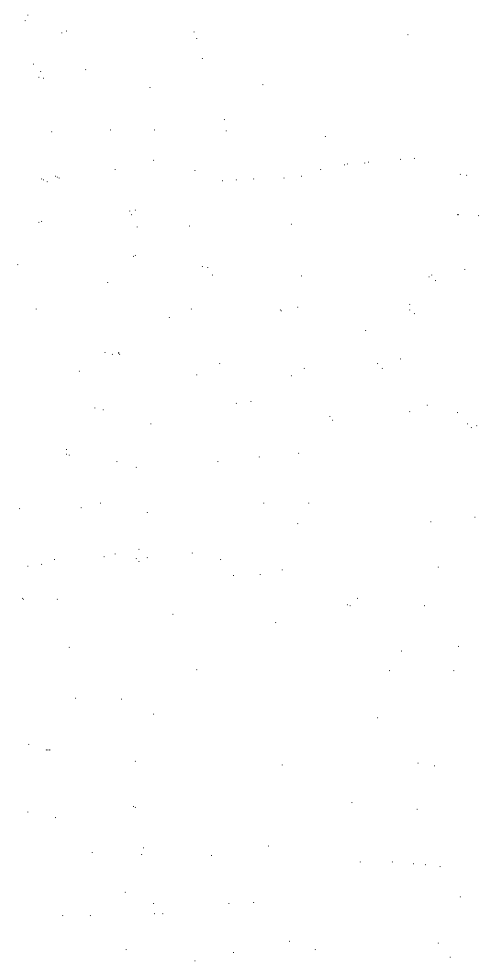

In [7]:
pcd_frames = [d['xyz'][0] for d in data[3:]]

diffs = []
for i in range(len(pcd_frames)-1):
  old_pcd = pcd_frames[i]
  new_pcd = pcd_frames[i+1]
  diff_map = np.linalg.norm(new_pcd - old_pcd, axis=-1)
  diff_map = diff_map.reshape(-1,32).T
  diff_map = diff_map > 0.001 
  diffs.append(diff_map)
  

n=20
fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(5, 0.5*n))
for i in range(n):
  axes[i].imshow(diffs[i], cmap='gray') #black means no update, white means update
  axes[i].axis('off')
  
plt.tight_layout()
plt.show()

# rendering time works and the pointcloud updates every frame, with correct positions